# I. About data

> - A Collection of 120 Psychology Patients with 17 Essential Symptoms to Diagnose Mania Bipolar Disorder, Depressive Bipolar Disorder, Major Depressive Disorder, and Normal Individuals. The dataset contains the 17 essential symptoms psychiatrists use to diagnose the described disorders. The behavioral symptoms are considered the levels of patients Sadness, Exhaustness, Euphoric, Sleep disorder, Mood swings, Suicidal thoughts, Anorexia, Anxiety, Try-explaining, Nervous breakdown, Ignore & Move-on, Admitting mistakes, Overthinking, Aggressive response, Optimism, Sexual activity, and Concentration in a Comma Separated Value (CSV) format. The Normal category refer to the individuals using therapy time for specialized counseling, personal development, and life skill enrichments. While such individuals may also have minor mental problems, they differ from those suffering from Major Depressive Disorder and Bipolar Disorder.

source --> [link](http://www.kaggle.com/datasets/cid007/mental-disorder-classification)

In [167]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

plt.style.use('fivethirtyeight')

################################
import pingouin as pg # for chi2_test

################################
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

################################
import warnings
warnings.filterwarnings("ignore")
print(5*'-'+'>')

----->


### Before we start our investigation, I have some concerns about the data: 
- **Representativeness of the sample :** We don't know if the sample represents the population, as we lack information on age, gender, race, and the data collection date.
- **Methodology** : The data lacks details on the scale, collection methods, and the meaning of some attributes. The source of the data is also unclear, raising ethical concerns.

> **Therefore, don't take the notebook results too seriously, as they might be misleading.**

In [168]:
#load_data
data = pd.read_csv('./Dataset-Mental-Disorders.csv')
data.head(2)

,Patient Number,Sadness,Euphoric,Exhausted,Sleep dissorder,Mood Swing,Suicidal thoughts,Anorxia,Authority Respect,Try-Explanation,Aggressive Response,Ignore & Move-On,Nervous Break-down,Admit Mistakes,Overthinking,Sexual Activity,Concentration,Optimisim,Expert Diagnose
0,Patiant-01,Usually,Seldom,Sometimes,Sometimes,YES,YES,NO,NO,YES,NO,NO,YES,YES,YES,3 From 10,3 From 10,4 From 10,Bipolar Type-2
1,Patiant-02,Usually,Seldom,Usually,Sometimes,NO,YES,NO,NO,NO,NO,NO,NO,NO,NO,4 From 10,2 From 10,5 From 10,Depression


In [169]:
# Some descriptive statistics 
data.describe(include='object',).T

,count,unique,top,freq
Patient Number,120,120,Patiant-01,1
Sadness,120,4,Usually,42
Euphoric,120,4,Seldom,46
Exhausted,120,4,Sometimes,38
Sleep dissorder,120,4,Sometimes,44
Mood Swing,120,2,NO,63
Suicidal thoughts,120,3,NO,63
Anorxia,120,2,NO,74
Authority Respect,120,2,NO,73
Try-Explanation,120,2,NO,63


# II. preprocessing

In [170]:
# drop Patient Number because it is not important 
data = data.drop(columns='Patient Number', axis=1)

# Replace any leading or trailing white spaces
data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Fixing column values 
data['Concentration'] = data['Concentration'].str.replace('From 10', '')
data['Optimisim'] = data['Optimisim'].str.replace('From 10', '')
data['Sexual Activity'] = data['Sexual Activity'].str.replace('From 10', '')

# map_labels 
mapping = {'Bipolar Type-2':0,
           'Depression':1,
           'Normal':2,
           'Bipolar Type-1':3}

data['Diagnose_maped'] = data['Expert Diagnose'].map(mapping)

print('data shape ---> ', data.shape)
data.head(3)

data shape --->  (120, 19)


,Sadness,Euphoric,Exhausted,Sleep dissorder,Mood Swing,Suicidal thoughts,Anorxia,Authority Respect,Try-Explanation,Aggressive Response,Ignore & Move-On,Nervous Break-down,Admit Mistakes,Overthinking,Sexual Activity,Concentration,Optimisim,Expert Diagnose,Diagnose_maped
0,Usually,Seldom,Sometimes,Sometimes,YES,YES,NO,NO,YES,NO,NO,YES,YES,YES,3,3,4,Bipolar Type-2,0
1,Usually,Seldom,Usually,Sometimes,NO,YES,NO,NO,NO,NO,NO,NO,NO,NO,4,2,5,Depression,1
2,Sometimes,Most-Often,Sometimes,Sometimes,YES,NO,NO,NO,YES,YES,NO,YES,YES,NO,6,5,7,Bipolar Type-1,3


# III. EDA

In [171]:
# categorical_cols = [col for col in data.columns if data[col].dtype == 'object']
col = ['Sadness', 'Euphoric', 'Exhausted', 'Sleep dissorder', 'Mood Swing',
       'Suicidal thoughts', 'Anorxia', 'Authority Respect', 'Try-Explanation',
       'Aggressive Response', 'Ignore & Move-On', 'Nervous Break-down',
       'Admit Mistakes', 'Overthinking', 'Sexual Activity', 'Concentration',
       'Optimisim'].copy()

Distribution of Expert Diagnoses (Balanced): 



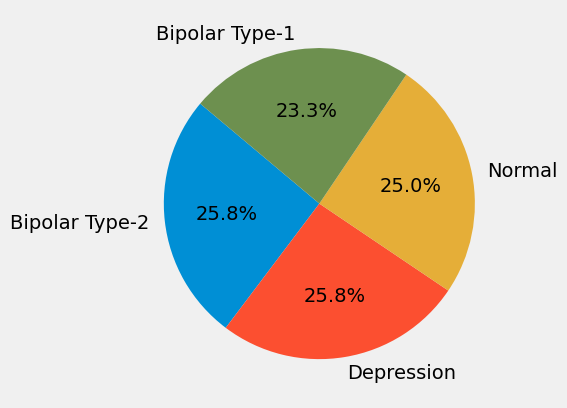

In [172]:
print('Distribution of Expert Diagnoses (Balanced): \n')
expert_diagnose_counts = data['Expert Diagnose'].value_counts()
plt.pie(expert_diagnose_counts, labels=expert_diagnose_counts.index, autopct='%1.1f%%', startangle=140)
# plt.title('Distribution of Expert Diagnoses')
plt.show()

In [173]:
# g = sns.FacetGrid(data, col='label_mapped')
# g.map(sns.histplot, 'Sadness') 
# # Box plots for each symptom by diagnosis group
# for symptom in encoded_data.columns:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x=symptom, y='Diagnose_maped', data=data)
#     plt.title(f'{symptom} by Diagnosis Group')
#     plt.show()
# plt.show()

Distribution of all features:



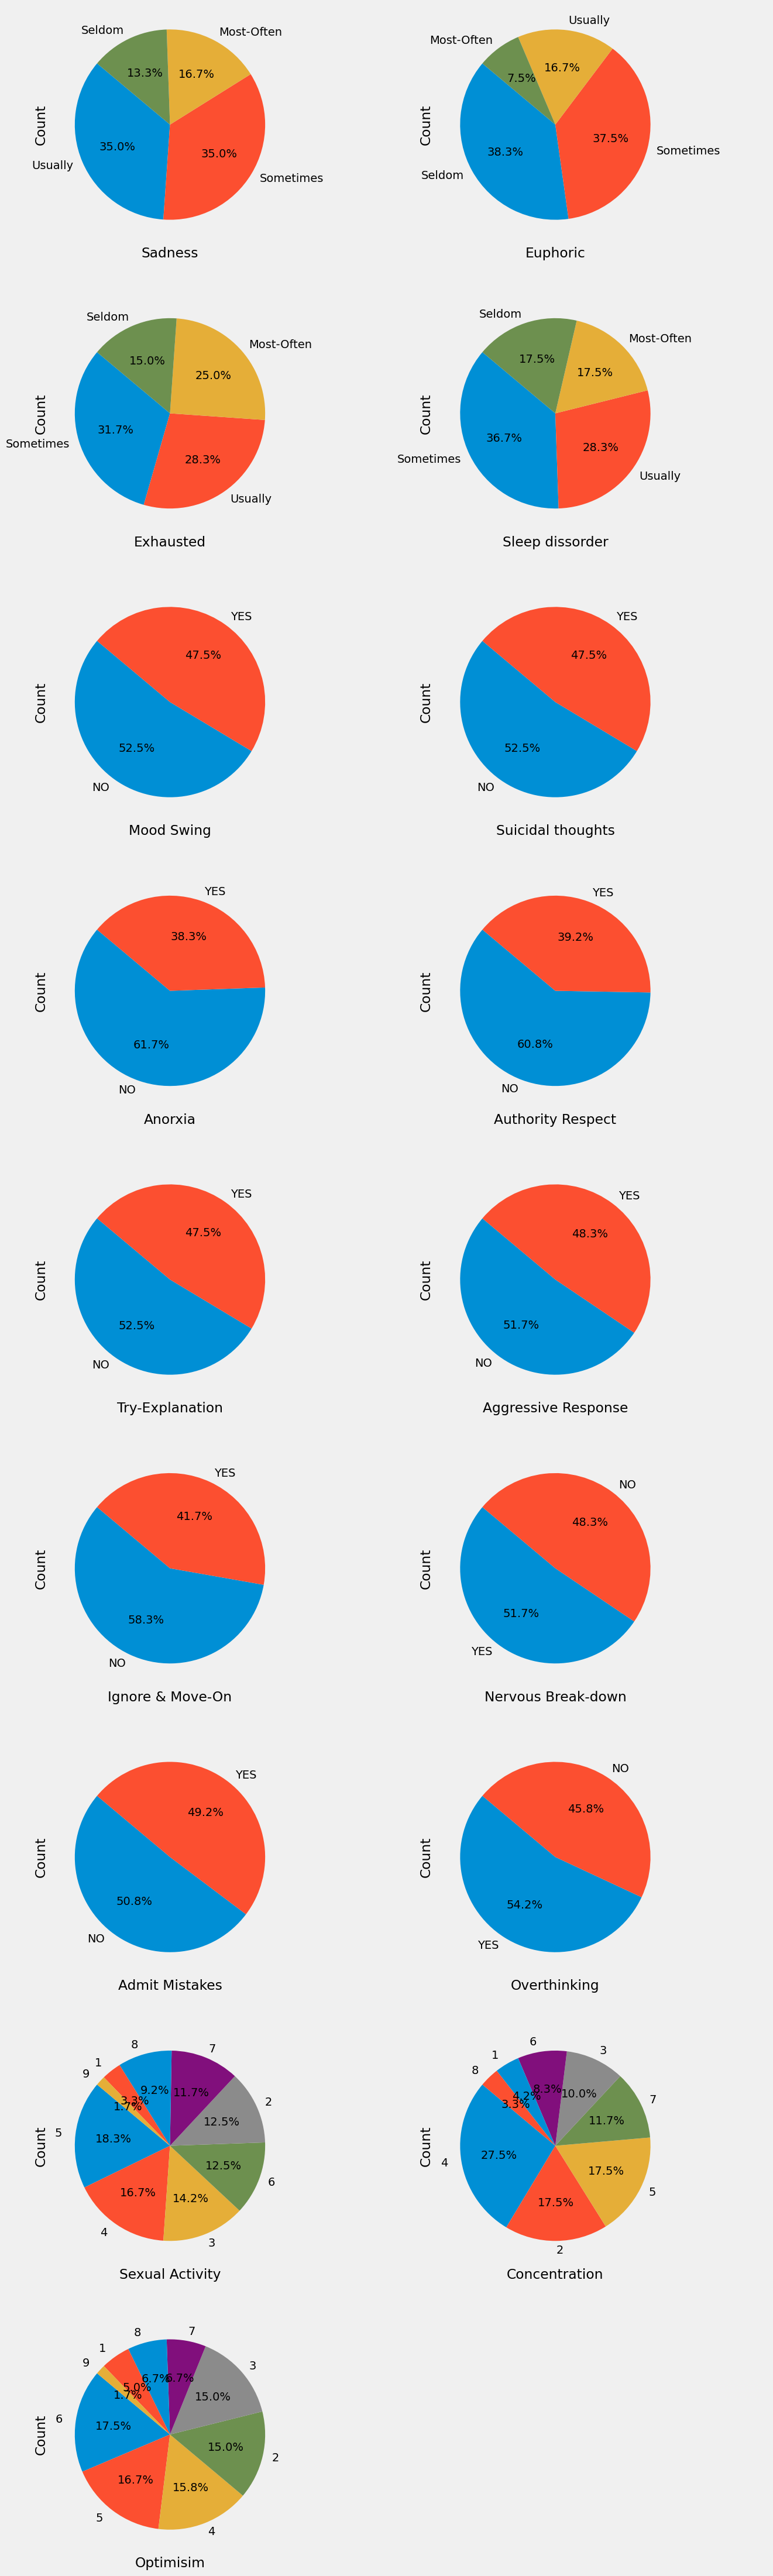

In [174]:
print('Distribution of all features:\n')

num_rows = (len(col) + 1) // 2

fig, axs = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows))

axs = axs.flatten()

for i, c in enumerate(col):
    expert_diagnose_counts = data[c].value_counts()
    
    if not expert_diagnose_counts.empty:
        axs[i].pie(expert_diagnose_counts, labels=expert_diagnose_counts.index, autopct='%1.1f%%', startangle=140)
        axs[i].set_xlabel(c)
        axs[i].set_ylabel("Count")
    else:
        axs[i].axis('off')

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout(pad=3.0)
plt.show()

The distribution of the target variable (Expert Diagnose) in each feature :



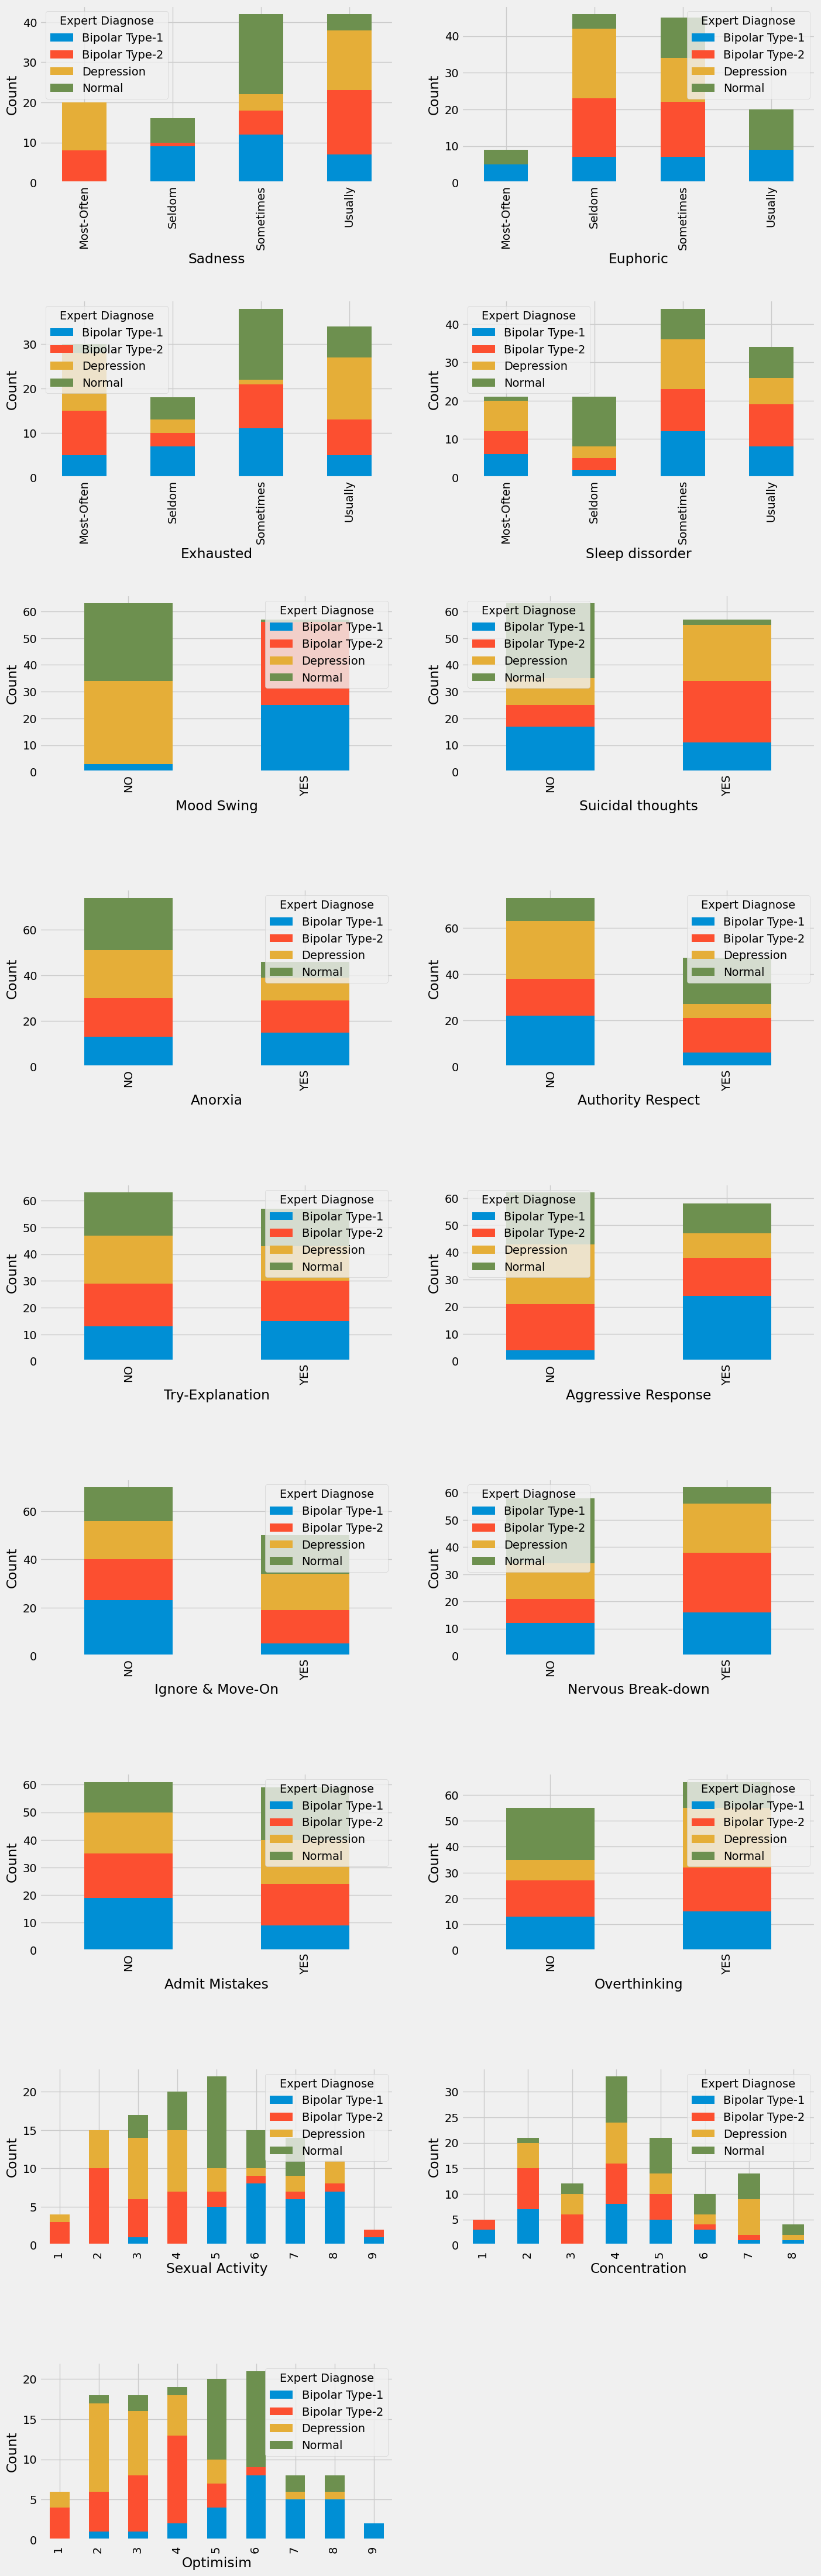

In [175]:
print('The distribution of the target variable (Expert Diagnose) in each feature :\n')

num_rows = (len(col) + 1) // 2

fig, axs = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows))

axs = axs.flatten()

for i, c2 in enumerate(col):
    grouped_data = data.groupby([c2, 'Expert Diagnose']).size().unstack()
    
    if not grouped_data.empty:
        grouped_data.plot(kind='bar', stacked=True, ax=axs[i])
        axs[i].set_xlabel(c2)
        axs[i].set_ylabel("Count")
    else:
        axs[i].axis('off')

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout(pad=3.0)
plt.show()

> Based on the above visualizations, we observe some interesting results. Specifically, examining the "optimism" feature (last stacked bar chart), it reveals significant insights into "expert diagnoses". When the optimism scale is four or lower, patients often receive diagnoses of Bipolar II or Depressive Bipolar Disorder. As the scale surpasses four, there is a noticeable shift toward diagnoses among individuals categorized as normal. Moreover, beyond a scale of seven, patients are more frequently diagnosed with Bipolar I.

Let's check our observation !!

Correlation Matrix: 



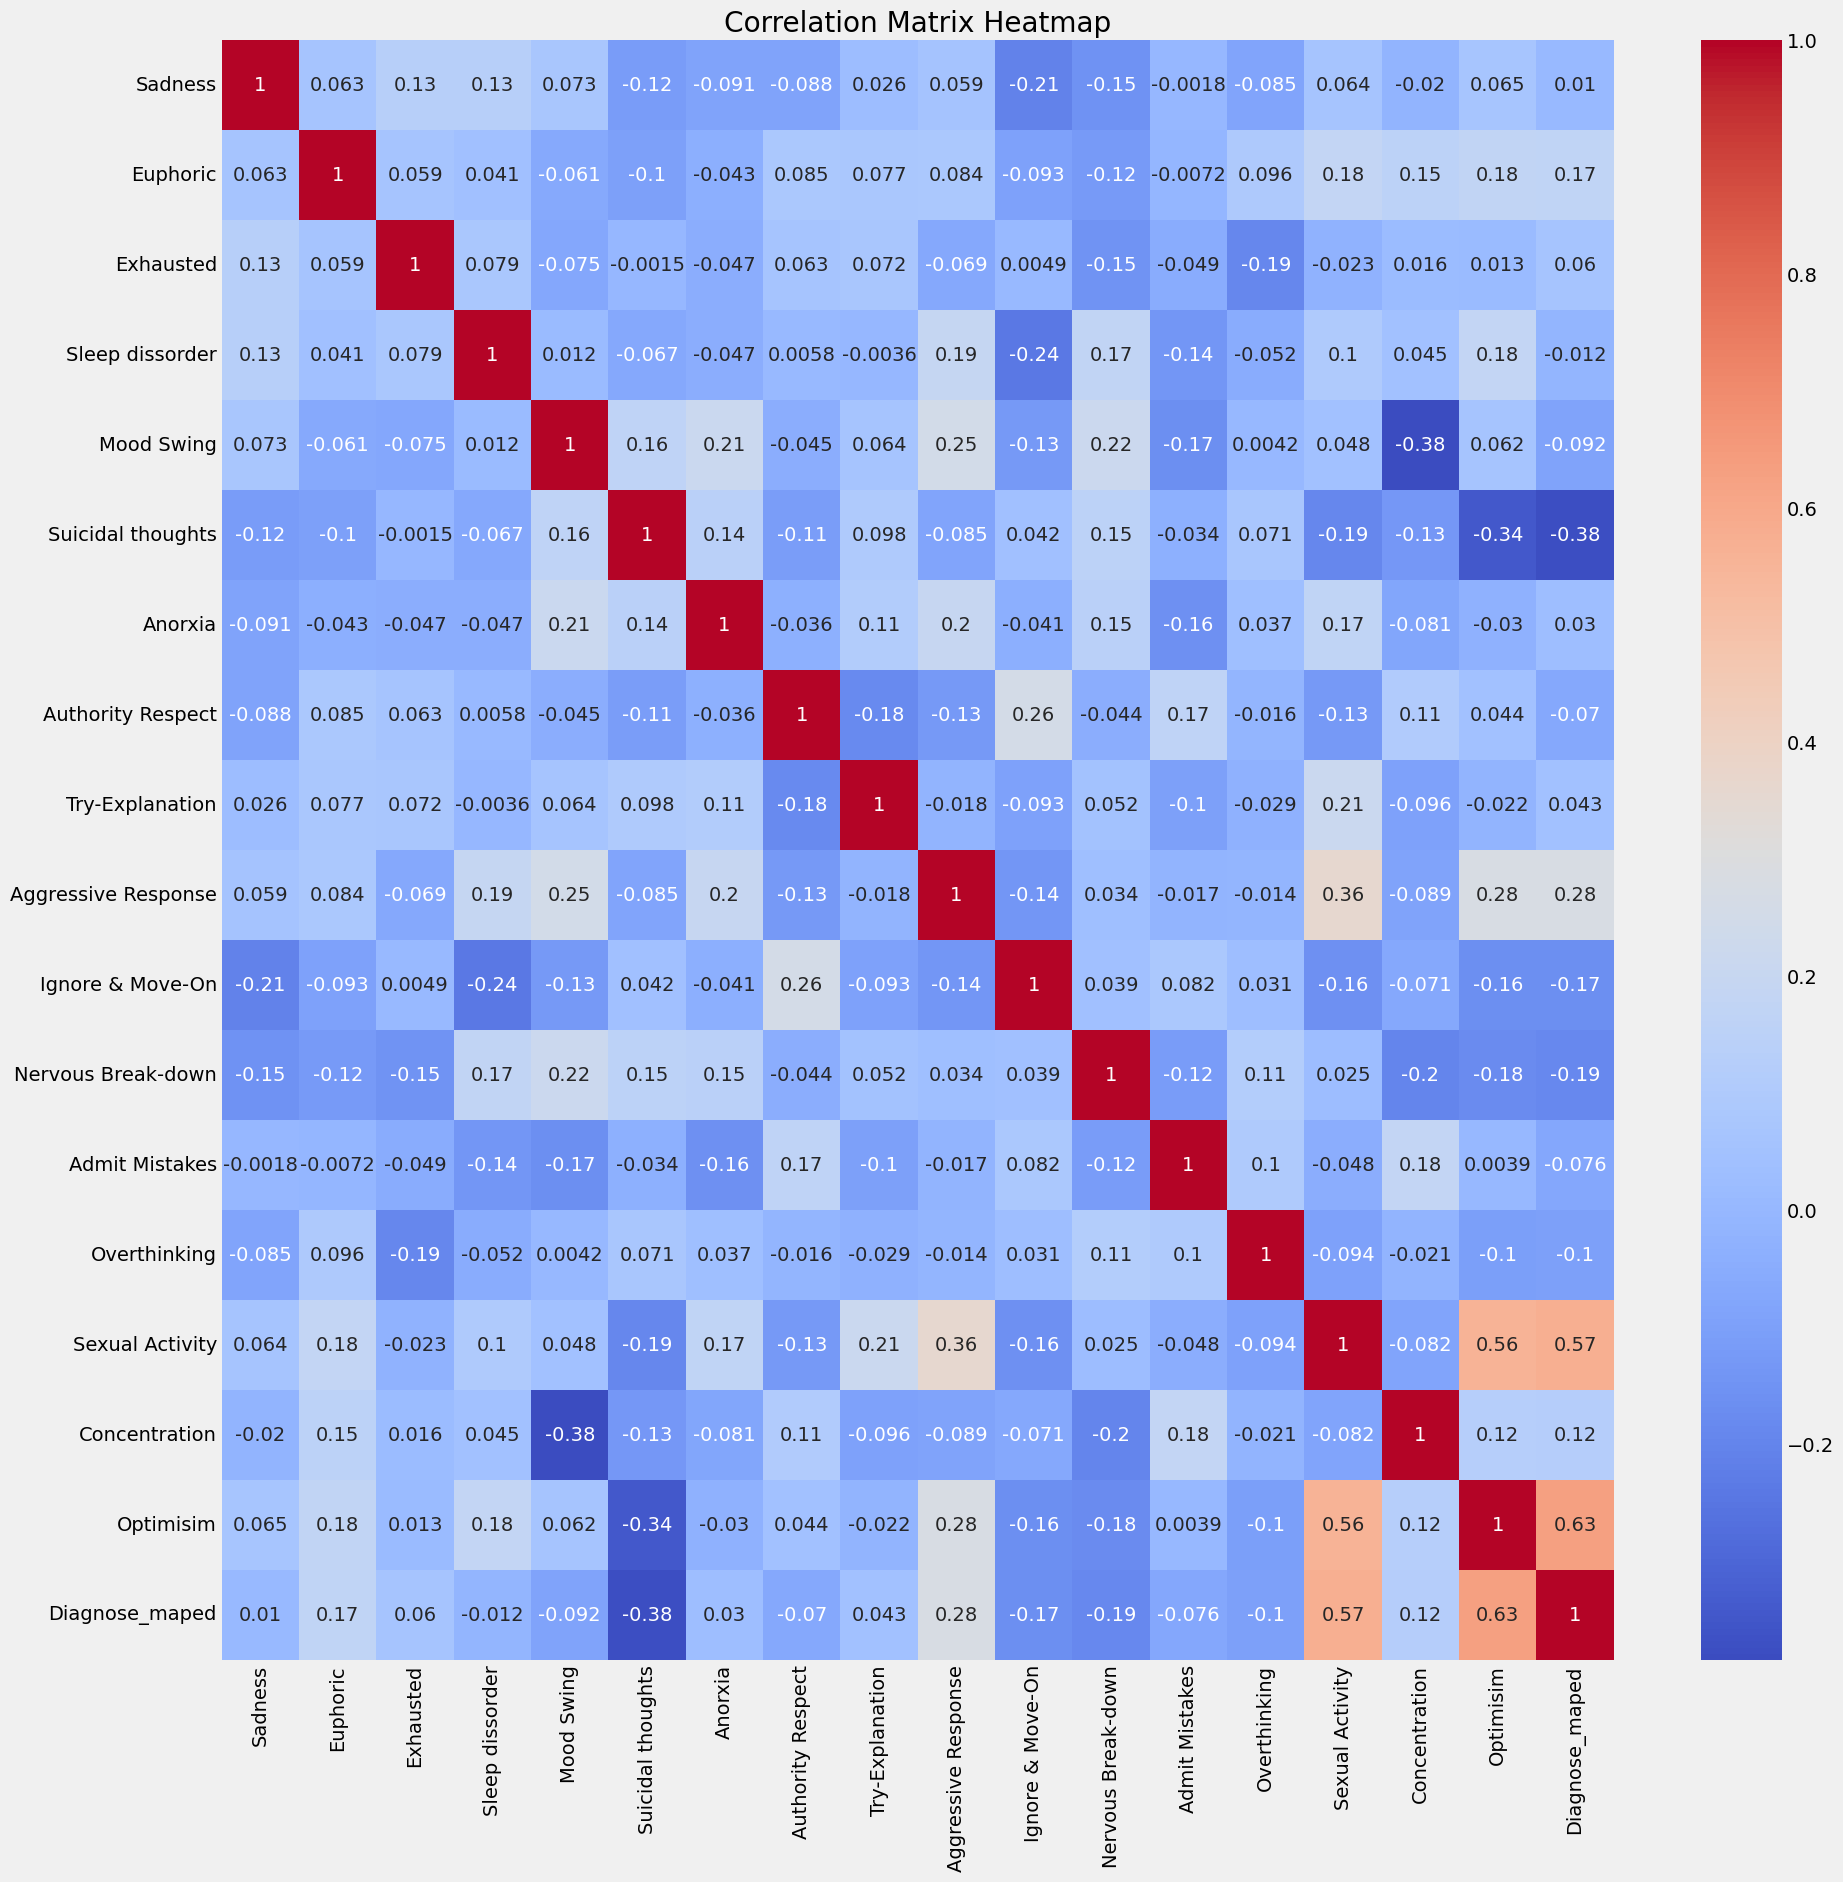

In [176]:
print('Correlation Matrix: \n')
      
ordinal_encoder = OrdinalEncoder()

encoded_data = data.copy()

encoded_data[col] = ordinal_encoder.fit_transform(encoded_data[col])
encoded_data = encoded_data.drop('Expert Diagnose',axis=1)

corr_matrix = encoded_data.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

Correlation matrix between features and expert diagnosis: 



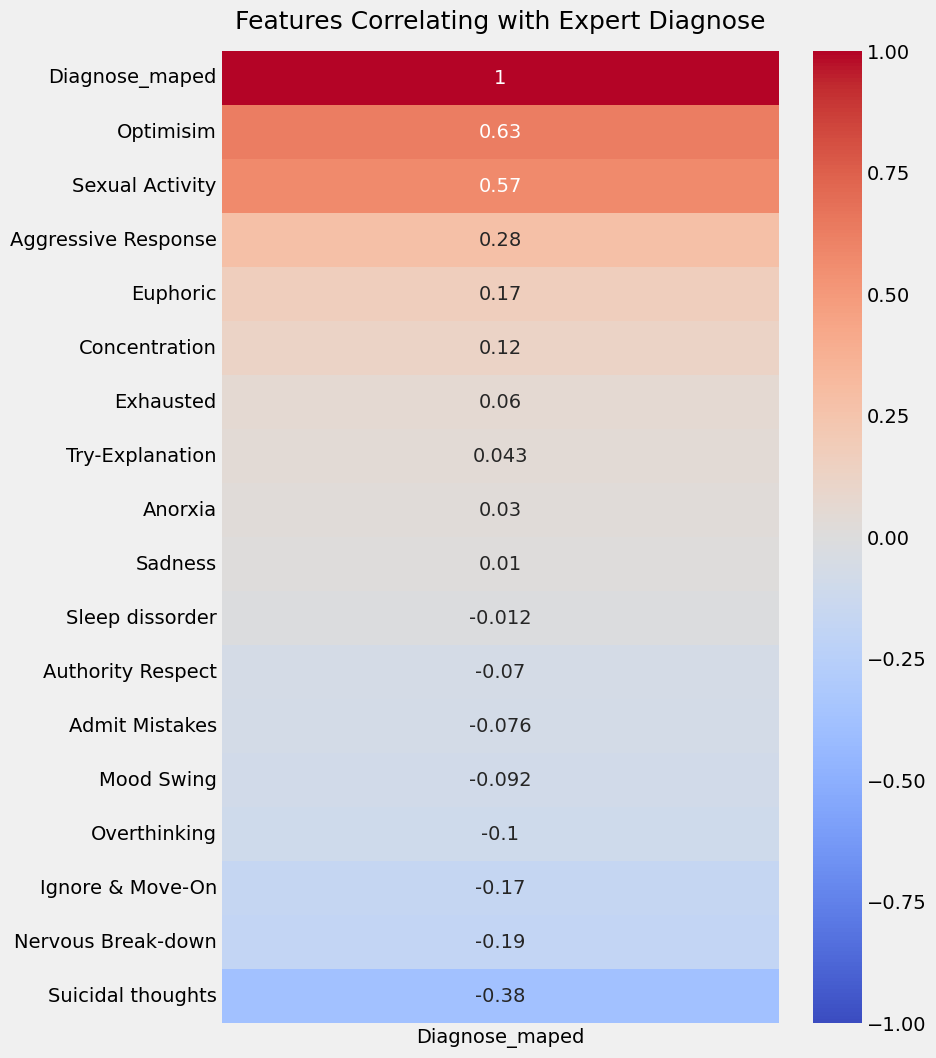

In [177]:
print('Correlation matrix between features and expert diagnosis: \n')

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(encoded_data.corr()[['Diagnose_maped']].sort_values(by='Diagnose_maped',
                                                                           ascending=False), vmin=-1,
                                                                           vmax=1, annot=True, cmap='coolwarm')

heatmap.set_title('Features Correlating with Expert Diagnose', fontdict={'fontsize':18}, pad=16);

In [178]:
# chi_2 for association between variables and target .
print(' Chi-square of independence between featuers and Target (Expert Diagnose): \n')
dfs = []
for c in col:
    expected, observed, stats= pg.chi2_independence(data, x=c, y='Expert Diagnose')
    df = pd.DataFrame({'Features': [c], 'Chi2': stats['chi2'].iloc[0], 'P-value': stats['pval'].iloc[0]})
    dfs.append(df)
    
results_df = pd.concat(dfs, ignore_index=True)
results_df = results_df.sort_values(by='Chi2', ascending=False)
results_df.set_index('Features',inplace=True)
results_df.style.background_gradient(subset=["Chi2", "P-value"])
# results_df[["Chi2"]].plot(kind='bar',figsize=(12, 5))
# plt.show()

 Chi-square of independence between featuers and Target (Expert Diagnose): 



,Chi2,P-value
Features,,
Mood Swing,105.382504,0.000000
Optimisim,88.959020,0.000000
Sexual Activity,76.483768,0.000000
Sadness,59.633778,0.000000
Euphoric,45.615154,0.000001
Suicidal thoughts,34.767256,0.000000
Concentration,30.157765,0.088863
Exhausted,29.307723,0.000575
Sleep dissorder,22.604199,0.007149


In [179]:
target = 'Diagnose_maped'

X = encoded_data.drop(columns=['Diagnose_maped'], axis= 1)
y = encoded_data[target]
X.shape, y.shape

((120, 17), (120,))

In [180]:
# print('Mutual Information Score -')
# le = LabelEncoder()
# # Encode all categorical features
# for en in col:
#     X[en] = le.fit_transform(X[en].astype(str))

# mi_df = pd.DataFrame(columns=['Features', 'Mutual Information'])

# for c3 in col:
#     mi = mutual_info_classif(X[[c3]], y, discrete_features=True)# Calculate mutual information
    
#     mi_df.loc[len(mi_df)] = {'Features': c3, 'Mutual Information': mi[0]}

# mi_df.set_index('Features',inplace= True)
# mi_df = mi_df.sort_values(by='Mutual Information', ascending=False).plot(kind="bar",figsize=(12, 5))
# plt.title('Mutual Information Score - ')
# plt.xticks(rotation=75)
# plt.show()

# IV. Modling

In [181]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((96, 17), (24, 17), (96,), (24,))

In [182]:
#lr
lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [183]:
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr_clf.coef_[0]})
coef_df.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
4,Mood Swing,2.351216
5,Suicidal thoughts,0.875098
12,Admit Mistakes,0.786643
3,Sleep dissorder,0.618516
6,Anorxia,0.263727
8,Try-Explanation,0.198457
7,Authority Respect,0.096575
11,Nervous Break-down,0.058151
10,Ignore & Move-On,0.037935
2,Exhausted,-0.107107


In [184]:
scores = cross_val_score(lr_clf, X, y,
                        scoring='accuracy', 
                        cv=5)
print("Cross validation score - 5 fold:\n")
print("mean :",np.mean(scores))
print("std  :",np.std(scores))

Cross validation score - 5 fold:

mean : 0.7833333333333333
std  : 0.05527707983925665




classification_report: 
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.83      0.83      0.83         6
           2       0.86      1.00      0.92         6
           3       0.71      0.83      0.77         6

    accuracy                           0.83        24
   macro avg       0.85      0.83      0.83        24
weighted avg       0.85      0.83      0.83        24





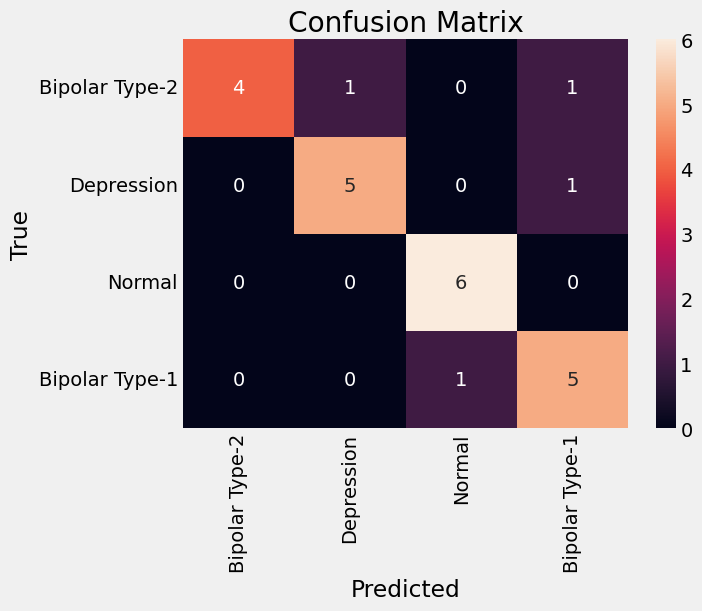

In [185]:
predictions = lr_clf.predict(X_test)

print('\n')
print('classification_report: \n',format(metrics.classification_report(y_test, predictions)))
print('\n')

labels=['Bipolar Type-2','Depression','Normal','Bipolar Type-1']
cf_matrix = metrics.confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix, annot=True, fmt='d', 
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [186]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

Epoch 1/85 - Train Loss: 1.3864, Test Loss: 1.3410, Test Accuracy: 62.50%
Epoch 2/85 - Train Loss: 1.3567, Test Loss: 1.3102, Test Accuracy: 70.83%
Epoch 3/85 - Train Loss: 1.3139, Test Loss: 1.2791, Test Accuracy: 79.17%
Epoch 4/85 - Train Loss: 1.2981, Test Loss: 1.2468, Test Accuracy: 87.50%
Epoch 5/85 - Train Loss: 1.2472, Test Loss: 1.2129, Test Accuracy: 83.33%
Epoch 6/85 - Train Loss: 1.2262, Test Loss: 1.1755, Test Accuracy: 83.33%
Epoch 7/85 - Train Loss: 1.1679, Test Loss: 1.1335, Test Accuracy: 83.33%
Epoch 8/85 - Train Loss: 1.1337, Test Loss: 1.0883, Test Accuracy: 79.17%
Epoch 9/85 - Train Loss: 1.0970, Test Loss: 1.0407, Test Accuracy: 79.17%
Epoch 10/85 - Train Loss: 1.0339, Test Loss: 0.9907, Test Accuracy: 79.17%
Epoch 11/85 - Train Loss: 0.9965, Test Loss: 0.9445, Test Accuracy: 79.17%
Epoch 12/85 - Train Loss: 0.9946, Test Loss: 0.8979, Test Accuracy: 79.17%
Epoch 13/85 - Train Loss: 0.8827, Test Loss: 0.8513, Test Accuracy: 79.17%
Epoch 14/85 - Train Loss: 0.8203, 

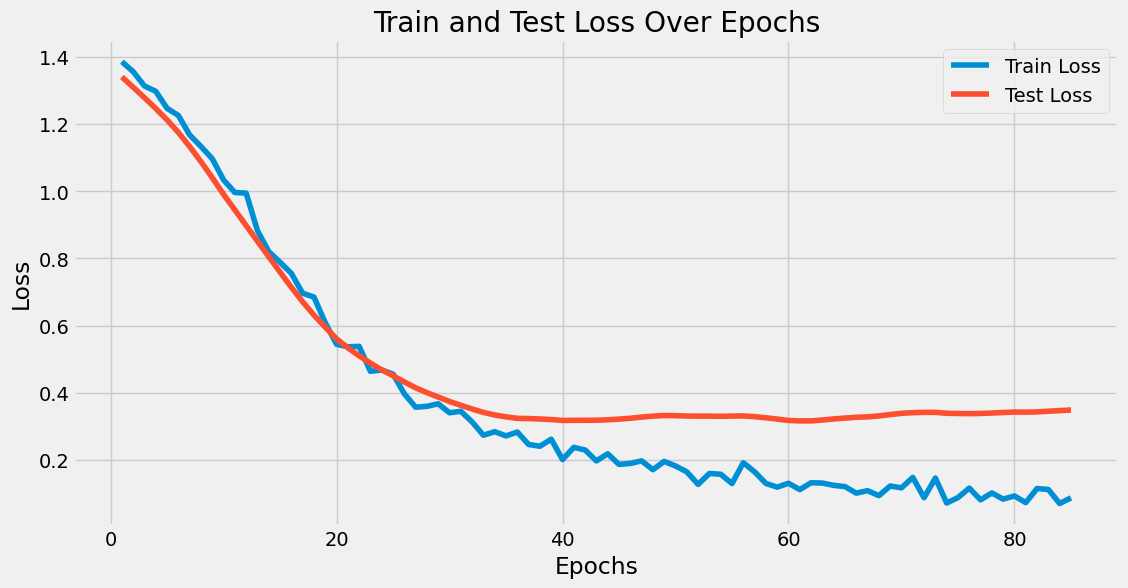

Final Test Accuracy: 91.67%


In [187]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Define the MLP model
class ImprovedMLP(nn.Module):
    def __init__(self, input_size, h1, h2, output_size, dropout_rate=0.3):
        super(ImprovedMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, h1),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(h1, h2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(h2, output_size)
        )

    def forward(self, x):
        return self.network(x)

# Initialize model, loss, and optimizer
input_size = 17
h1 = 128  # Increased neurons
h2 = 64   # Increased neurons
output_size = 4

model = ImprovedMLP(input_size, h1, h2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Add weight decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)  # Learning rate scheduler

# Training the model
epochs = 85  # More epochs
batch_size = 32
train_size = X_train.size(0)

train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for i in range(0, train_size, batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= (train_size // batch_size)
    train_losses.append(train_loss)

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test).item()
        test_losses.append(test_loss)

        # Compute accuracy
        y_pred = torch.argmax(test_outputs, dim=1)
        test_accuracy = accuracy_score(y_test.numpy(), y_pred.numpy())
        test_accuracies.append(test_accuracy)

    # Step the learning rate scheduler
    scheduler.step()

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

# Plotting train and test loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Loss Over Epochs")
plt.legend()
plt.show()

# Final Evaluation
print(f"Final Test Accuracy: {test_accuracies[-1] * 100:.2f}%")

#### "If you find this notebook helpful, please leave an upvote and feedback." thank you¶¶